<a href="https://colab.research.google.com/github/danwein8/Stable-Diffusion/blob/main/StableDiffusion2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install unet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import torch
import urllib
import numpy as np
import PIL
from unet import UNet
import shutil
from PIL import Image

In [ ]:
device = torch.device("cuda:0")

In [ ]:
def get_sample_image()-> PIL.Image.Image:
  url = 'https://cdn.britannica.com/84/232784-050-1769B477/Siberian-Husky-dog.jpg'
  filename = 'husky.jpg'
  urllib.request.urlretrieve(url, filename)
  return PIL.Image.open(filename)

In [ ]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

In [ ]:
def plot_noise_prediction(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

In [ ]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def forward(self, x_0, t, device):
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device)

    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns
        the denoised image.
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick the values from vals
        according to the indices stored in `t`
        """
        result = values.gather(-1, t.cpu())
        """
        if
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3

        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)

        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


In [ ]:
IMAGE_SHAPE = (64, 64)

In [ ]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE), # Resize the input image
    transforms.ToTensor(), # Convert to torch tensor (scales data into [0,1])
    transforms.Lambda(lambda t: (t * 2) - 1), # Scale data between [-1, 1]
])


reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2), # Scale data between [0,1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    transforms.Lambda(lambda t: t * 255.), # Scale data between [0.,255.]
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), # Convert into an uint8 numpy array
    transforms.ToPILImage(), # Convert to PIL image
])

In [ ]:
pil_image = get_sample_image()
torch_image = transform(pil_image)

In [ ]:
torch_image.shape

torch.Size([3, 64, 64])

In [ ]:
diffusion_model = DiffusionModel()

<Figure size 1500x1500 with 0 Axes>

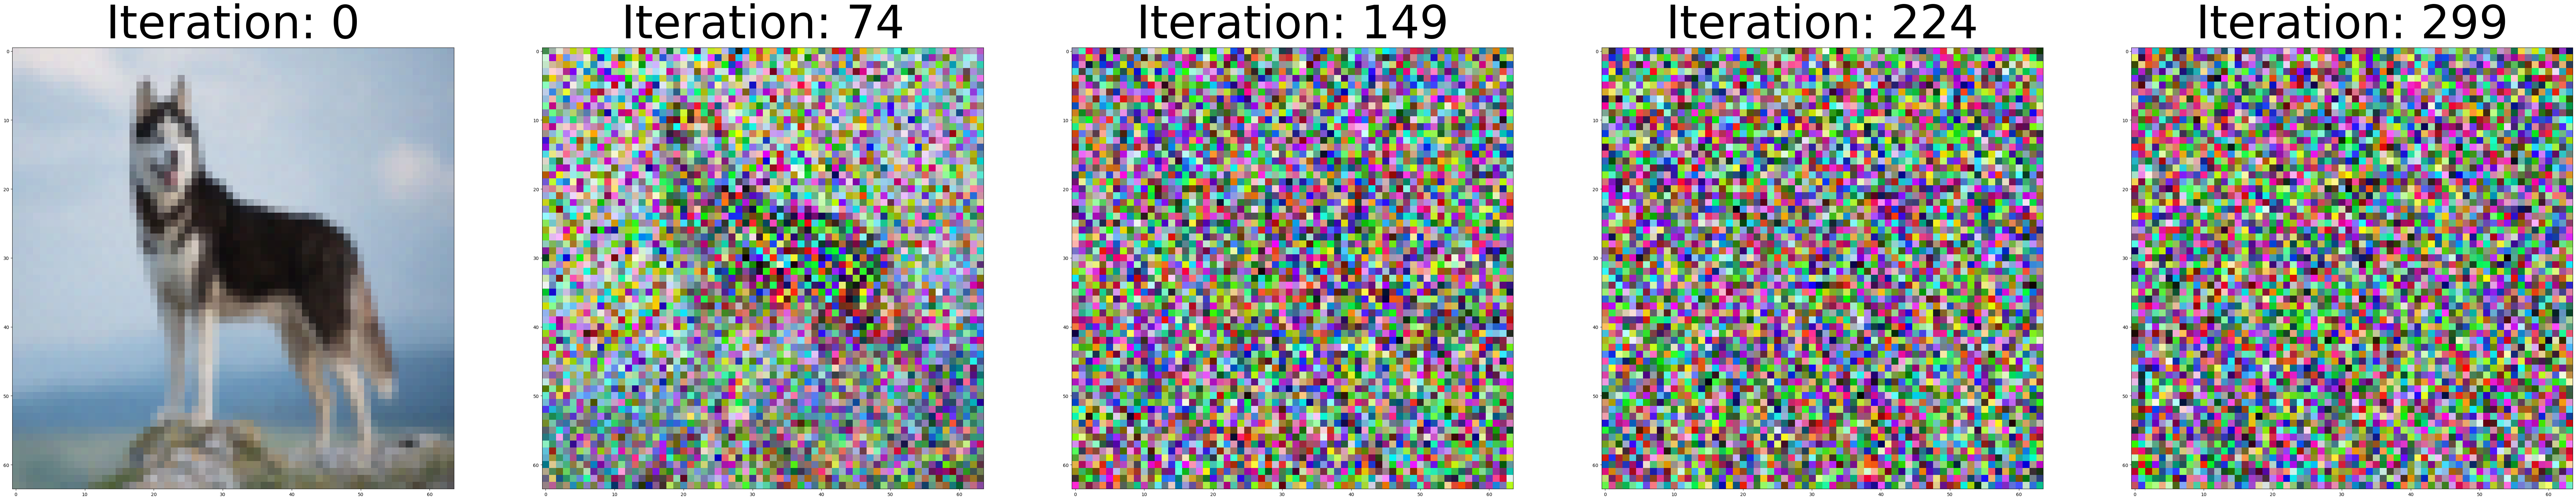

In [ ]:
NO_DISPLAY_IMAGES = 5
torch_image_batch = torch.stack([torch_image] * NO_DISPLAY_IMAGES)
t = torch.linspace(0, diffusion_model.timesteps - 1, NO_DISPLAY_IMAGES).long()
noisy_image_batch, _ = diffusion_model.forward(torch_image_batch, t, device)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(1, NO_DISPLAY_IMAGES, figsize = (100,100))

for idx, image in enumerate(noisy_image_batch):
    ax[idx].imshow(reverse_transform(image))
    ax[idx].set_title(f"Iteration: {t[idx].item()}", fontsize = 100)
plt.show()

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [ ]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()

        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)

        self.downsample = downsample

        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)

        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)

        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time[(..., ) + (None, ) * 2]
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]

        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)

In [ ]:
class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)

        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)


    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)

        return self.conv2(o)

In [ ]:
# NO_EPOCHS = 2000
# PRINT_FREQUENCY = 400
# LR = 0.001
# BATCH_SIZE = 128
# VERBOSE = True

# unet = UNet(labels=False)
# unet.to(device)
# optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

---
Epoch: 0 | Train Loss 1.0344979763031006


<Figure size 1500x1500 with 0 Axes>

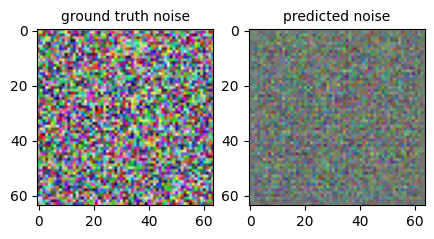

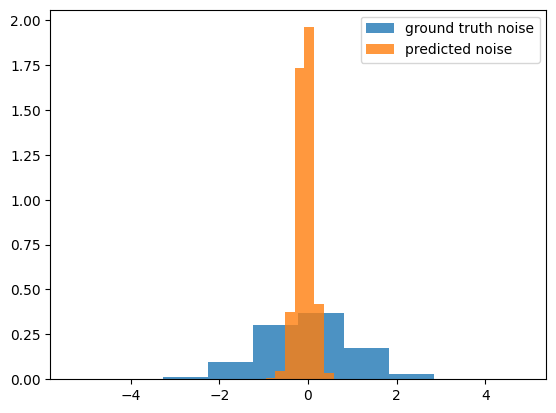

---
Epoch: 400 | Train Loss 0.03565560653805733


<Figure size 1500x1500 with 0 Axes>

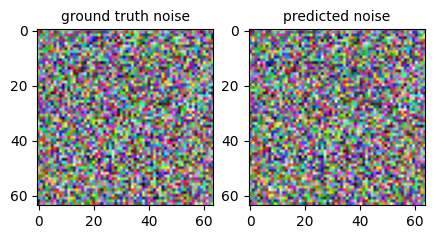

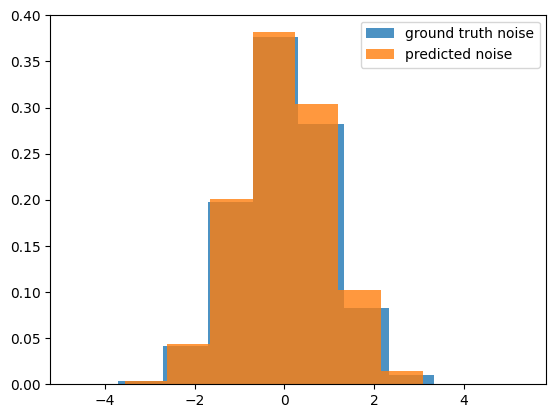

---
Epoch: 800 | Train Loss 0.01391175389289856


<Figure size 1500x1500 with 0 Axes>

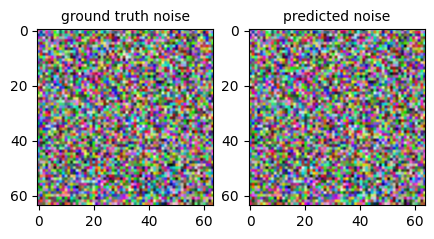

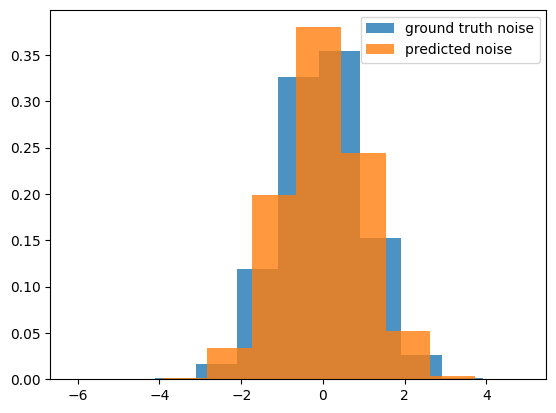

---
Epoch: 1200 | Train Loss 0.0073869843035936356


<Figure size 1500x1500 with 0 Axes>

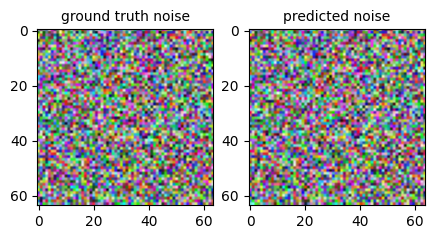

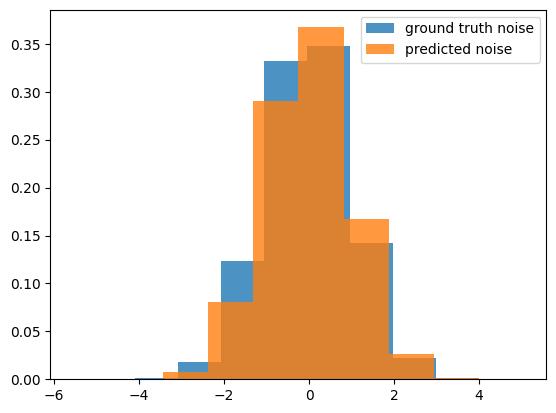

---
Epoch: 1600 | Train Loss 0.036669231951236725


<Figure size 1500x1500 with 0 Axes>

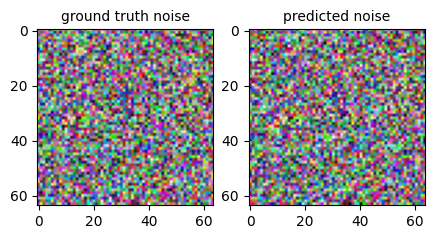

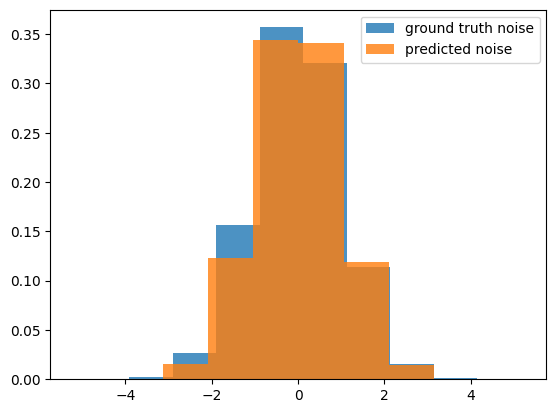

In [ ]:
# for epoch in range(NO_EPOCHS):
#     mean_epoch_loss = []

#     batch = torch.stack([torch_image] * BATCH_SIZE)
#     t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)

#     batch_noisy, noise = diffusion_model.forward(batch, t, device)
#     predicted_noise = unet(batch_noisy, t)

#     optimizer.zero_grad()
#     loss = torch.nn.functional.mse_loss(noise, predicted_noise)
#     mean_epoch_loss.append(loss.item())
#     loss.backward()
#     optimizer.step()

#     if epoch % PRINT_FREQUENCY == 0:
#         print('---')
#         print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")
#         if VERBOSE:
#             with torch.no_grad():
#                 plot_noise_prediction(noise[0], predicted_noise[0])
#                 plot_noise_distribution(noise, predicted_noise)

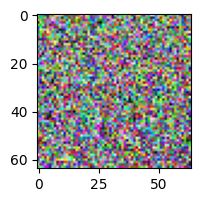

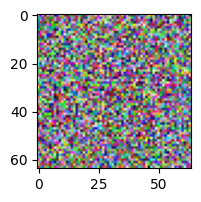

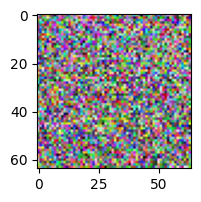

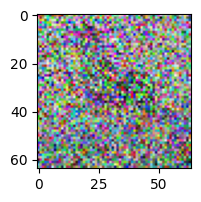

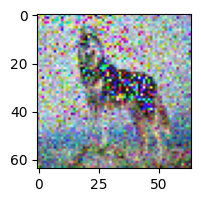

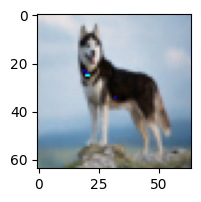

In [ ]:
# with torch.no_grad():
#     img = torch.randn((1, 3) + IMAGE_SHAPE).to(device)
#     for i in reversed(range(diffusion_model.timesteps)):
#         t = torch.full((1,), i, dtype=torch.long, device=device)
#         img = diffusion_model.backward(img, t, unet.eval())
#         if i % 50 == 0:
#             plt.figure(figsize=(2,2))
#             plt.imshow(reverse_transform(img[0]))
#             plt.show()

In [ ]:
BATCH_SIZE = 256
NO_EPOCHS = 200
PRINT_FREQUENCY = 10
LR = 0.001
VERBOSE = False

unet = UNet(labels=True)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, drop_last=True)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [ ]:
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    for batch, label in trainloader:
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = diffusion_model.forward(batch, t, device)
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    for batch, label in testloader:

        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)

        batch_noisy, noise = diffusion_model.forward(batch, t, device)
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

        loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        mean_epoch_loss_val.append(loss.item())

    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)

        torch.save(unet.state_dict(), f"epoch: {epoch}")

---
Epoch: 0 | Train Loss 0.15117995681670995 | Val Loss 0.04287700125804314
---
Epoch: 10 | Train Loss 0.026014859592303253 | Val Loss 0.025076236098240584
---
Epoch: 20 | Train Loss 0.02185778340850121 | Val Loss 0.021675384292999905
---
Epoch: 30 | Train Loss 0.020966549781270515 | Val Loss 0.020618560700080335
---
Epoch: 40 | Train Loss 0.020465562836481974 | Val Loss 0.020023795513388436
---
Epoch: 50 | Train Loss 0.020049954129335208 | Val Loss 0.020244875588478185
---
Epoch: 60 | Train Loss 0.01992931291460991 | Val Loss 0.020092496457390297
---
Epoch: 70 | Train Loss 0.01954138756562502 | Val Loss 0.019675262726079196
---
Epoch: 80 | Train Loss 0.019601843506097793 | Val Loss 0.019821391226007387
---
Epoch: 90 | Train Loss 0.019429784210828634 | Val Loss 0.019863794295069497
---
Epoch: 100 | Train Loss 0.019185987611611683 | Val Loss 0.019320803431746286
---
Epoch: 110 | Train Loss 0.019193903509622964 | Val Loss 0.019380746695857782
---
Epoch: 120 | Train Loss 0.01922308217065

In [ ]:
unet = UNet(labels=True)
unet.load_state_dict(torch.load(("epoch: 170")))

<All keys matched successfully>

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
NUM_CLASSES = len(classes)
NUM_DISPLAY_IMAGES = 5

In [ ]:
torch.manual_seed(16)

plt.figure(figsize=(20,20))
f, ax = plt.subplots(NUM_CLASSES, NUM_DISPLAY_IMAGES, figsize = (100,100))

for c in range(NUM_CLASSES):
    imgs = torch.randn((NUM_DISPLAY_IMAGES, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([c] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
        imgs = diffusion_model.backward(x=imgs, t=t, model=unet.eval().to(device), labels = labels)
    for idx, img in enumerate(imgs):
        ax[c][idx].imshow(reverse_transform(img))
        ax[c][idx].set_title(f"Class: {classes[c]}", fontsize = 100)

plt.show()

<Figure size 2000x2000 with 0 Axes>

In [ ]:
shutil.copy("/content/epoch: 170","/content/drive/MyDrive/ColabNotebooks/Stable Diffusion")

'/content/drive/MyDrive/ColabNotebooks/Stable Diffusion/epoch: 170'

In [ ]:
shutil.copy("/content/epoch: 180","/content/drive/MyDrive/ColabNotebooks/Stable Diffusion")
shutil.copy("/content/epoch: 190","/content/drive/MyDrive/ColabNotebooks/Stable Diffusion")
shutil.copy("/content/epoch: 160","/content/drive/MyDrive/ColabNotebooks/Stable Diffusion")
shutil.copy("/content/epoch: 150","/content/drive/MyDrive/ColabNotebooks/Stable Diffusion")
shutil.copy("/content/epoch: 140","/content/drive/MyDrive/ColabNotebooks/Stable Diffusion")
shutil.copy("/content/epoch: 130","/content/drive/MyDrive/ColabNotebooks/Stable Diffusion")
shutil.copy("/content/epoch: 120","/content/drive/MyDrive/ColabNotebooks/Stable Diffusion")
shutil.copy("/content/epoch: 110","/content/drive/MyDrive/ColabNotebooks/Stable Diffusion")
shutil.copy("/content/epoch: 100","/content/drive/MyDrive/ColabNotebooks/Stable Diffusion")

'/content/drive/MyDrive/ColabNotebooks/Stable Diffusion/epoch: 100'

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.5 MB/s eta 0:00:00


In [ ]:
!python -c "from datasets import load_dataset; print(load_dataset('squad', split='train')[0])"

Extracting data files: 100% 2/2 [00:00<00:00, 2112.47it/s]
Generating train split: 100% 87599/87599 [00:06<00:00, 14472.78 examples/s]
Generating validation split: 100% 10570/10570 [00:00<00:00, 13145.61 examples/s]
{'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', '

In [ ]:
!pip install datasets[vision]

In [ ]:
data1 = "BirdL/NGA_Art" # no description, no features, no split, too small 500 items
data2 = "newsletter/SDXL-Artists" # no description, no features, no split, almost 4000 items
data3 = "youssef101/artelingo-dummy" # maybe, not really sure whats going on here
data4 = "StyleMuseum/homare_fool_s_art"
data5 = "youssef101/artelingo"
data6 = "image-search-2/unsplash_lite_image_dataset"
data7 = "frgfm/imagewoof"

In [ ]:
from datasets import load_dataset_builder
ds_builder = load_dataset_builder(data7, '160px')

In [ ]:
ds_builder.info.description

"Imagewoof is a subset of 10 classes from Imagenet that aren't so \neasy to classify, since they're all dog breeds. The breeds are: \nAustralian terrier, Border terrier, Samoyed, Beagle, Shih-Tzu, \nEnglish foxhound, Rhodesian ridgeback, Dingo, Golden retriever, \nOld English sheepdog.\nAll images were resized on their shortest side to 160 pixels."

In [ ]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['Australian terrier', 'Border terrier', 'Samoyed', 'Beagle', 'Shih-Tzu', 'English foxhound', 'Rhodesian ridgeback', 'Dingo', 'Golden retriever', 'Old English sheepdog'], id=None)}

In [ ]:
from datasets import get_dataset_split_names

get_dataset_split_names(data7, '160px')

['train', 'validation']

In [ ]:
from datasets import load_dataset
dataset = load_dataset(data7, '160px')

Generating train split:   0%|          | 0/9025 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3929 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9025
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 3929
    })
})

In [ ]:
dataset['train'].shape

(9025, 2)

In [ ]:
dataset['validation'].shape

(3929, 2)

In [ ]:
type(dataset['train'])

datasets.arrow_dataset.Dataset

In [ ]:
type(dataset['train']['image'])

list

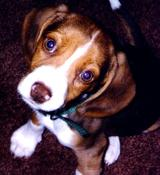

In [ ]:
dataset['train']['image'][0]

In [ ]:
dataset['train']['label'][0]

2

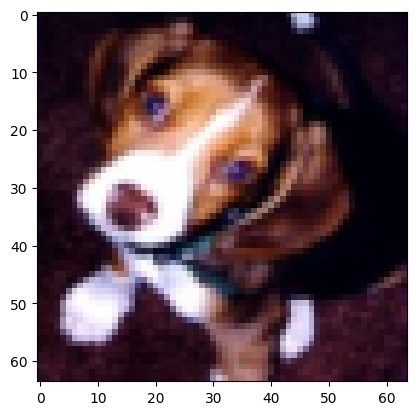

In [ ]:
a = transform(dataset['train']['image'][0])
plt.imshow(reverse_transform(a))

In [ ]:
transformed_data = []
transformed_val = []
for image in dataset['train']['image']:
  transformed_data.append(transform(image))

for image in dataset['validation']['image']:
  transformed_val.append(transform(image))

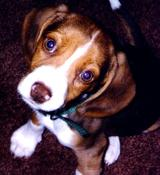

In [ ]:
trainloader2.dataset['image'][0]

In [ ]:
BATCH_SIZE = 256
NO_EPOCHS = 50
PRINT_FREQUENCY = 10
LR = 0.0003
VERBOSE = False

diffusion_model = DiffusionModel()
unet = UNet(labels=True)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [ ]:
trainset = torchvision.datasets.OxfordIIITPet(root='./data', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)
trainloader2 = torch.utils.data.DataLoader(transformed_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)

testset = torchvision.datasets.OxfordIIITPet(root='./data', split='test', download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, drop_last=True)
testloader2 = torch.utils.data.DataLoader(transformed_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, drop_last=True)

In [ ]:
for epoch in range(NO_EPOCHS):
  mean_epoch_loss = []
  mean_epoch_loss_val = []
  for batch, label in trainloader:
    t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
    batch = batch.to(device)
    batch_noisy, noise = diffusion_model.forward(batch, t, device)
    predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(noise, predicted_noise)
    mean_epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()

  for batch, label in testloader:
    t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
    batch = batch.to(device)
    batch_noisy, noise = diffusion_model.forward(batch, t, device)
    predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

    loss = torch.nn.functional.mse_loss(noise, predicted_noise)
    mean_epoch_loss_val.append(loss.item())

  if epoch % PRINT_FREQUENCY == 0:
    print('---')
    print(f'Epoch: {epoch} | Train Loss: {np.mean(mean_epoch_loss)} | Val Loss: {np.mean(mean_epoch_loss_val)}')
    if VERBOSE:
      with torch.no_grad():
        plot_noise_prediction(noise[0], predicted_noise[0])
        plot_noise_distribution(noise, predicted_noise)

    torch.save(unet.state_dict(), f"Dog{epoch}.pth")

AttributeError: ignored

In [ ]:
for i in range(810):
  if i % 10 == 0:
    shutil.copy(f"/content/Dog{i}.pth","/content/drive/MyDrive/ColabNotebooks/Stable Diffusion")

In [ ]:
shutil.copy(f"/content/Dog800.pth","/content/drive/MyDrive/ColabNotebooks/Stable Diffusion")

'/content/drive/MyDrive/ColabNotebooks/Stable Diffusion/Dog800.pth'

In [ ]:
torch.load(("Dog800.pth")).keys()

odict_keys(['downsampling.0.label_mlp.weight', 'downsampling.0.label_mlp.bias', 'downsampling.0.conv1.weight', 'downsampling.0.conv1.bias', 'downsampling.0.final.weight', 'downsampling.0.final.bias', 'downsampling.0.bnorm1.weight', 'downsampling.0.bnorm1.bias', 'downsampling.0.bnorm1.running_mean', 'downsampling.0.bnorm1.running_var', 'downsampling.0.bnorm1.num_batches_tracked', 'downsampling.0.bnorm2.weight', 'downsampling.0.bnorm2.bias', 'downsampling.0.bnorm2.running_mean', 'downsampling.0.bnorm2.running_var', 'downsampling.0.bnorm2.num_batches_tracked', 'downsampling.0.conv2.weight', 'downsampling.0.conv2.bias', 'downsampling.0.time_mlp.weight', 'downsampling.0.time_mlp.bias', 'downsampling.1.label_mlp.weight', 'downsampling.1.label_mlp.bias', 'downsampling.1.conv1.weight', 'downsampling.1.conv1.bias', 'downsampling.1.final.weight', 'downsampling.1.final.bias', 'downsampling.1.bnorm1.weight', 'downsampling.1.bnorm1.bias', 'downsampling.1.bnorm1.running_mean', 'downsampling.1.bnorm1

In [ ]:
unet = UNet()
unet.load_state_dict(torch.load(("Dog770.pth")))

RuntimeError: ignored

In [ ]:
NUM_DISPLAY_IMAGES = 5

<Figure size 1000x1000 with 0 Axes>

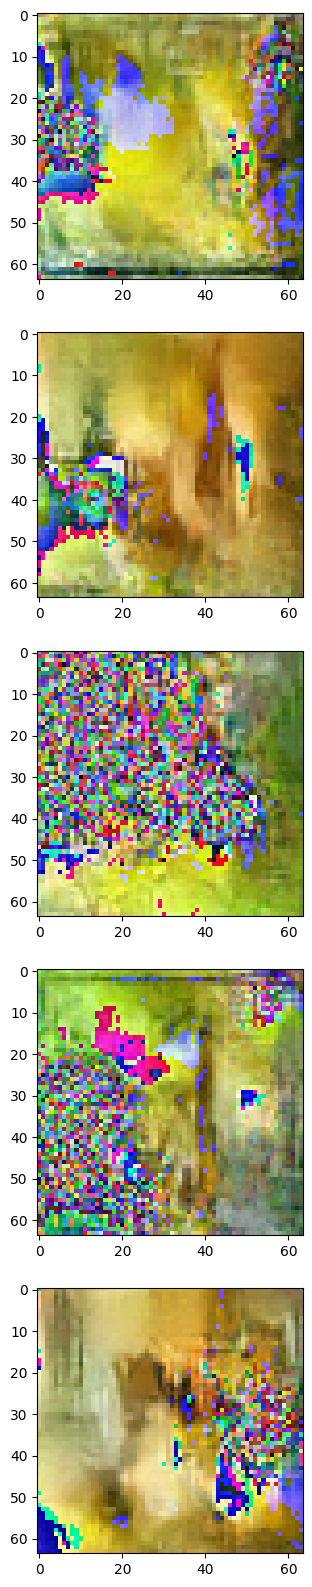

In [ ]:
torch.manual_seed(8)
plt.figure(figsize=(10,10))
f, ax = plt.subplots(NUM_DISPLAY_IMAGES, figsize=(20,20))

imgs = torch.randn((NUM_DISPLAY_IMAGES, 3) + IMAGE_SHAPE).to(device)
for i in reversed(range(diffusion_model.timesteps)):
  t = torch.full((1,), i, dtype=torch.long, device=device)
  imgs = diffusion_model.backward(x=imgs, t=t, model=unet.eval().to(device))
for idx, img in enumerate(imgs):
  ax[idx].imshow(reverse_transform(img))

plt.show()

# BREAK

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)

In [ ]:
!nvidia-smi

Tue Aug 22 20:53:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    60W /  70W |   5603MiB / 15360MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Adding noise to the image
<br>

You add noise to the image to essentially destroy all information using a markov chain. The noise at timestep `t` can be computed, so even though the noise in timestep `t` is dependant on the noise in timestep `t - 1`, we dont need to calculate all timesteps, just the last.

In [ ]:
def foward_diffusion(x0, t, beta = torch.linspace(0.0, 1.0, 5)):
  rand_noise = torch.rand_like(x0) # random tensor with values sampled from N(0,1)
  alpha = 1 - beta # set alpha to 1-beta
  alpha_hat = torch.cumprod(alpha, axis=0) # alpha_hat is a cumulative product of the alpha tensor
  alpha_hat_t = alpha_hat.gather(-1, t).reshape(-1, 1, 1, 1) # get alpha_hat values at each timestep t and reshape to same shape as image

  # Using alpha_hat_t values get mean and variance values
  mean = alpha_hat_t.sqrt() * x0
  variance = torch.sqrt(1 - alpha_hat_t) * rand_noise
  return mean + variance, rand_noise

In [ ]:
# Dummy
x0 = torch.randn(2, 3, 32, 32)

In [ ]:
# Dummy linear noise schedule
beta = torch.tensor([0.05, 0.1, 0.15, 0.2, 0.25])

In [ ]:
url = 'https://cdn.britannica.com/84/232784-050-1769B477/Siberian-Husky-dog.jpg'

In [ ]:
filename = 'husky.jpg'

In [ ]:
urllib.request.urlretrieve(url, filename)

('husky.jpg', <http.client.HTTPMessage at 0x7f8111e87040>)

In [ ]:
from PIL import Image

In [ ]:
image = Image.open(filename)

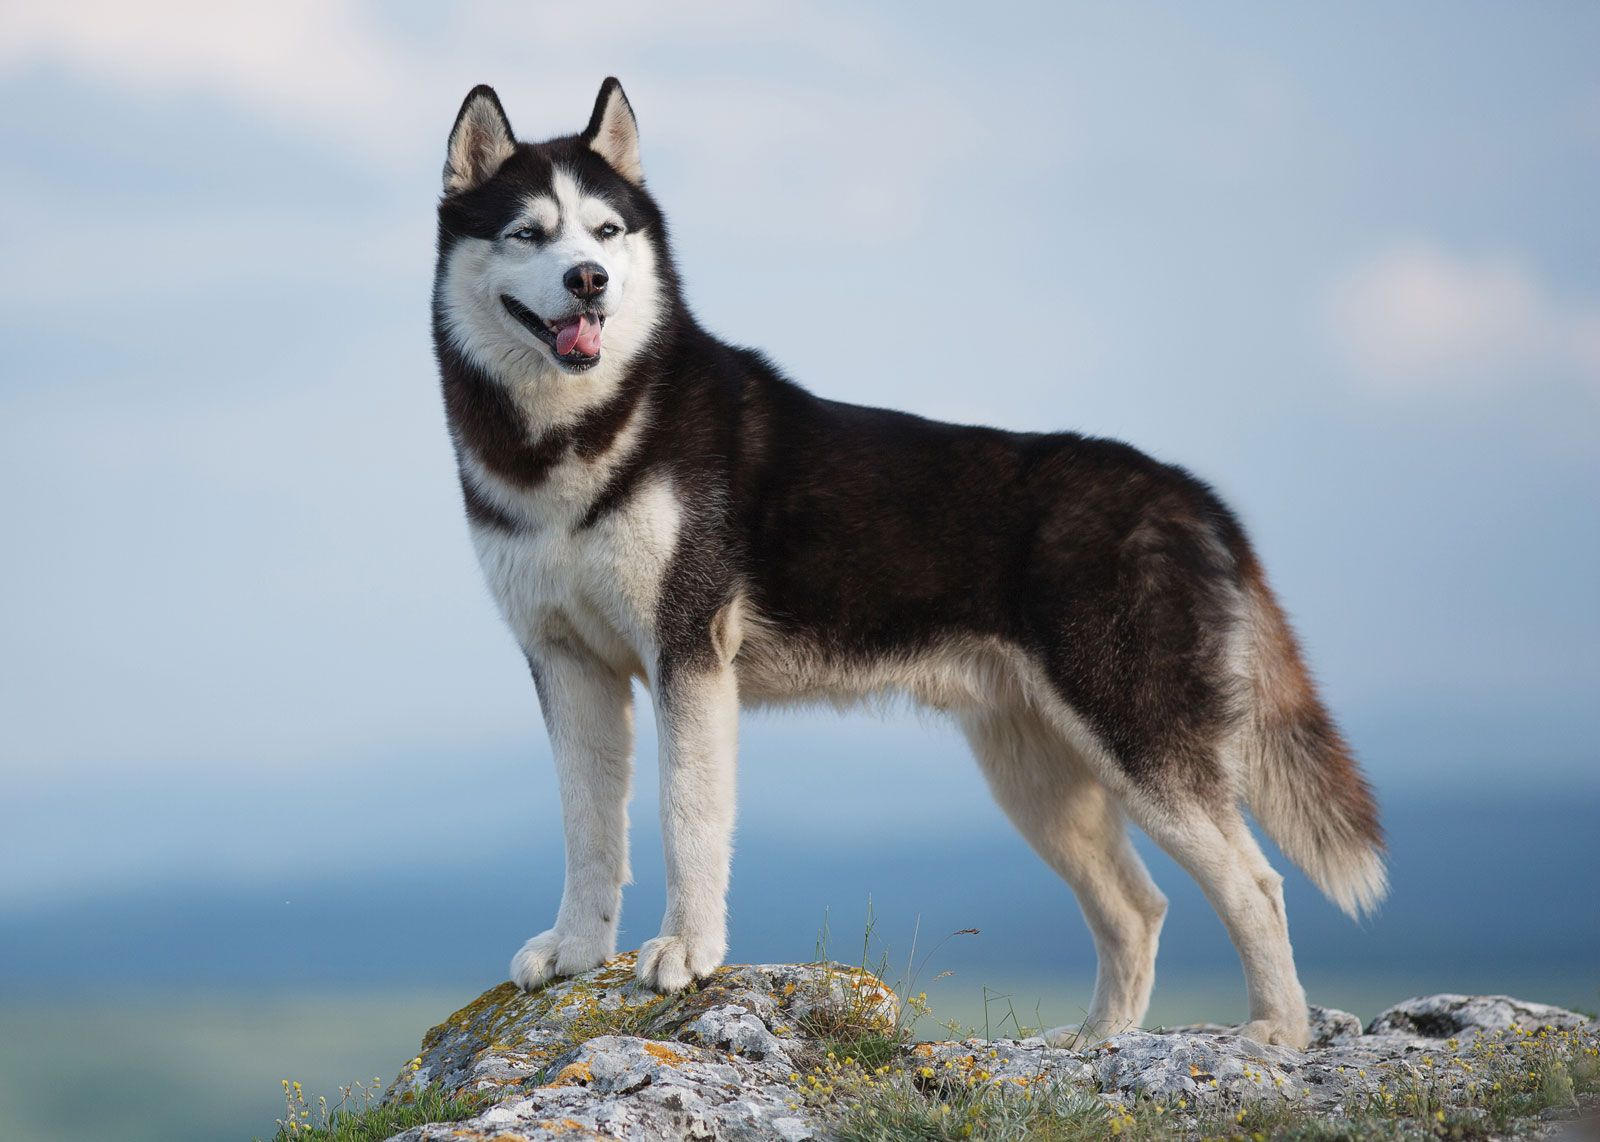

In [ ]:
image

In [ ]:
torch_image = transform(image)

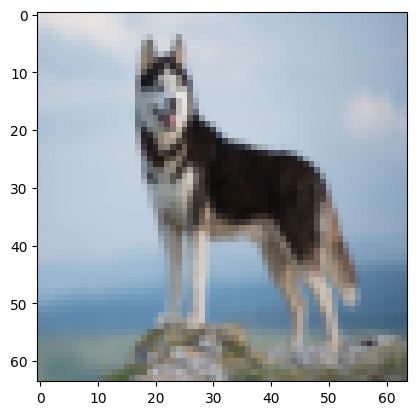

In [ ]:
plt.imshow(reverse_transform(torch_image))

In [ ]:
t = torch.tensor([0, 1, 2, 3, 4])
batch_images = torch.stack([torch_image] * 5)
noisy_images, _ = foward_diffusion(batch_images, t)

In [ ]:
noisy_images.size()

torch.Size([5, 3, 64, 64])

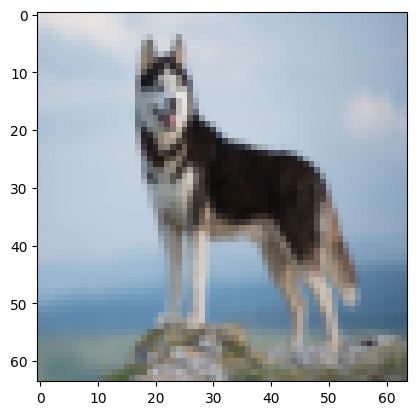

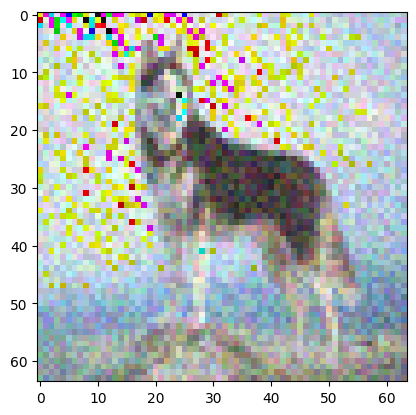

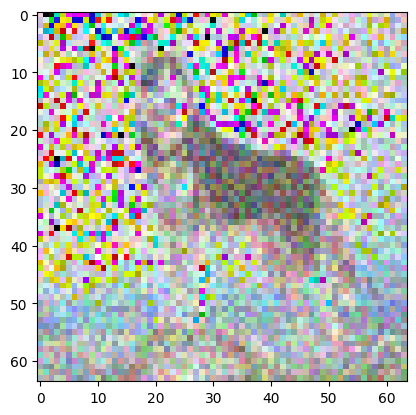

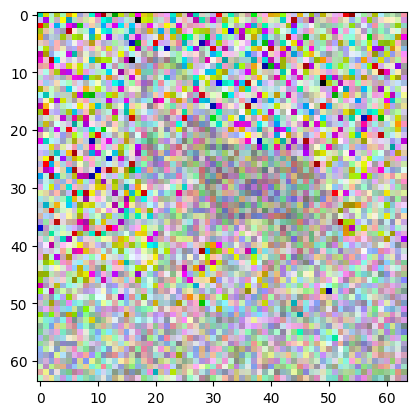

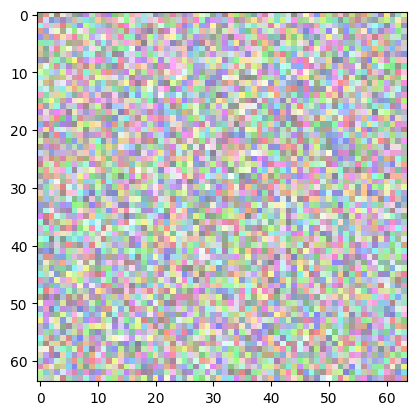

In [ ]:
for img in noisy_images:
  plt.imshow(reverse_transform(img))
  plt.show()